In [ ]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

# !pip install contractions
# import contractions
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


from absl import logging
import tensorflow as tf
import tensorflow_hub as hub

import re    #module for regular expression operations
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
Data = pd.read_csv('TrainData.csv')
# Data['Sentences'] = Data['Sentences'].apply(lambda x: '<sos>'+x+'<eos>')
# Data['Tags'] = Data['Tags'].apply(lambda x: )
Data.head()

,Sentences,Tags
0,what movies star bruce willis,O O O B-ACTOR I-ACTOR
1,show me films with drew barrymore from the 1980s,O O O O B-ACTOR I-ACTOR O O B-YEAR
2,what movies starred both al pacino and robert ...,O O O O B-ACTOR I-ACTOR O B-ACTOR I-ACTOR
3,find me all of the movies that starred harold ...,O O O O O O O O B-ACTOR I-ACTOR O B-ACTOR I-ACTOR
4,find me a movie with a quote about baseball in it,O O O O O O O O O O O


**Train-Test-Val split**

In [ ]:
val_split = 0.2
N = Data.values.shape[0]
train_data = Data.values[int(N*val_split):,0:2]
test_data = pd.read_csv("./TestData.csv").values

In [ ]:
val_data = train_data[:int(N*val_split),0:2]

In [ ]:
print(val_data.shape[0]+train_data.shape[0],N,test_data.shape[0])

9775 9775 2443


In [ ]:
print(train_data.shape)
print(val_data.shape)
print(test_data.shape)

(7820, 2)
(1955, 2)
(2443, 2)


In [ ]:
train_d , train_l = [i.split(' ') for i in train_data[:,0]], [i.split(' ') for i in train_data[:,1]]
val_d , val_l = [i.split(' ') for i in val_data[:,0]], [i.split(' ') for i in val_data[:,1]]
test_d , test_l = [i.split(' ') for i in test_data[:,0]], [i.split(' ') for i in test_data[:,1]]

In [ ]:
print('train wrong data')
for i in range(len(train_d)):
  if len(train_d[i])!=len(train_l[i]):
    print(len(train_d[i]), len(train_l[i]),'indx:',i)
print('val wrong data')
for i in range(len(val_d)):
  if len(val_d[i])!=len(val_l[i]):
    print(len(val_d[i]), len(val_l[i]),'indx:',i)
print('test wrong data')
for i in range(len(test_d)):
  if len(test_d[i])!=len(test_l[i]):
    print(len(test_d[i]), len(test_l[i]),'indx:',i)

train wrong data
val wrong data
test wrong data


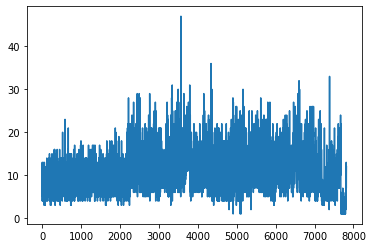

In [ ]:
plt.plot([len(sentence) for sentence in train_d])

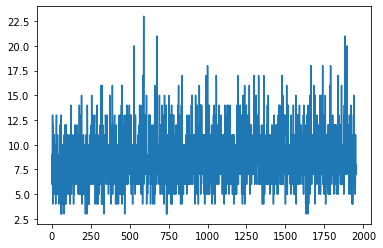

In [ ]:
plt.plot([len(sentence) for sentence in val_d])

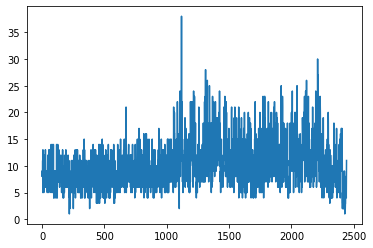

In [ ]:
plt.plot([len(sentence) for sentence in test_d])

In [ ]:
max_length = 30

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_d + val_d)
sequences = tokenizer.texts_to_sequences(train_d + val_d)

word_index = tokenizer.word_index
print("unique tokens except pad_token- "+str(len(word_index)))
vocab_size = len(tokenizer.word_index) + 1  #  with pad_token
print('vocab_size - '+str(vocab_size))

unique tokens except pad_token- 5969
vocab_size - 5970


In [ ]:
padded_lines = pad_sequences(sequences, maxlen=max_length, padding='post')

x_train_pad = padded_lines[0:-len(val_d)]
x_val_pad = padded_lines[-len(val_d):]
print(type(x_train_pad))

<class 'numpy.ndarray'>


In [ ]:
test_sequences = tokenizer.texts_to_sequences(test_d)
x_test_pad = pad_sequences(test_sequences, maxlen=max_length, padding = 'post')
X_test_pad = []
test_L = []
for k,i in enumerate(x_test_pad):
  if np.all(i==0)==False:
    X_test_pad.append(i)
    test_L.append(test_l[k])

x_test_pad = np.array(X_test_pad)
# test_l = np.array(test_L)

# label_sequences = label_tokenizer.texts_to_sequences(test_L)
# y_test_pad = pad_sequences(label_sequences, maxlen=max_length, padding='post')

# print(type(y_test_pad))

In [ ]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_l + val_l)
label_sequences = label_tokenizer.texts_to_sequences(train_l + val_l)

label_tokenizer.word_index['<pad>'] = 0
label_index = label_tokenizer.word_index
print("unique tokens except pad_token- "+str(len(label_index)))
label_vocab_size = len(label_tokenizer.word_index)  #  pad_token at 0th index
print('vocab_size - '+str(label_vocab_size))
# label_index["<pad>"] = 0

padded_lines = pad_sequences(label_sequences, maxlen=max_length, padding='post')

y_train_pad = padded_lines[0:-len(val_d)]
y_val_pad = padded_lines[-len(val_d):]
print(type(y_train_pad))


label_sequences = label_tokenizer.texts_to_sequences(test_L)
y_test_pad = pad_sequences(label_sequences, maxlen=max_length, padding='post')
print(type(y_test_pad))

unique tokens except pad_token- 26
vocab_size - 26
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [ ]:
label_tokenizer.word_index

{'<pad>': 0,
 'b-actor': 4,
 'b-character': 19,
 'b-director': 15,
 'b-genre': 2,
 'b-plot': 10,
 'b-rating': 11,
 'b-ratings_average': 13,
 'b-review': 22,
 'b-song': 21,
 'b-title': 8,
 'b-trailer': 24,
 'b-year': 6,
 'i-actor': 3,
 'i-character': 20,
 'i-director': 12,
 'i-genre': 17,
 'i-plot': 9,
 'i-rating': 16,
 'i-ratings_average': 14,
 'i-review': 23,
 'i-song': 18,
 'i-title': 5,
 'i-trailer': 25,
 'i-year': 7,
 'o': 1}

In [ ]:
!pip install torchkeras
!pip install pytorch-crf

In [ ]:
import torchkeras 
from torchcrf import CRF

In [ ]:
batch_size = 32
size = x_train_pad.shape[0]
X_train_batched = np.array_split(x_train_pad,size//batch_size)
y_train_batched = np.array_split(y_train_pad,size//batch_size)

X_val_batched = np.array_split(x_val_pad,size//batch_size)
y_val_batched = np.array_split(y_val_pad,size//batch_size)
n_steps = len(X_train_batched)


size = x_test_pad.shape[0]
x_test_batched = np.array_split(x_test_pad,size//batch_size)
y_test_batched = np.array_split(y_test_pad,size//batch_size)

In [ ]:
X_train_batched[10].shape

(33, 30)

In [ ]:
print(len(X_train_batched),n_steps)
label_vocab_size

244 244


26

In [ ]:
embedding_dim = 100
hidden_size = 64
# batch_size = 32
pad_id = 0

In [ ]:
class BiLSTM_CRF(torch.nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim,hidden_dim,device):
        super(BiLSTM_CRF, self).__init__()

        self.hidden_size = hidden_size

        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=pad_id)
        self.bi_lstm = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size // 2, batch_first=True,
                                     bidirectional=True)  # , dropout=0.2)

        
        self.hidden2tag = torch.nn.Linear(hidden_size, label_vocab_size) # excludes pad

        self.crf = CRF(num_tags=label_vocab_size , batch_first=True).to(device)

    def init_hidden(self, batch_size):
        return (torch.randn(2, batch_size, self.hidden_size // 2, device=device),
                torch.randn(2, batch_size, self.hidden_size // 2, device=device))  # ([batch=1,2,hidden_size//2], [batch=1,2,hidden_size//2])

    def forward(self, inp):  # inp [batch, seq_len=30], embedding_dim = 100
        self.bi_lstm.flatten_parameters()

        embeds = self.embedding(inp)  # [batch,seq_len]=>[batch, seq_len, embedding_dim]
        lstm_out, _ = self.bi_lstm(embeds, None)  # lstm_out: =>[batch, seq_len, hidden_size],
        # lstm_out, self.hidden = self.bi_lstm(embeds, self.hidden)  # lstm_out: =>[batch, seq_len, hidden_size],
        # h_n: ([batch,2,hidden_size//2], c_n: [batch,2,hidden_size//2])

        logits = self.hidden2tag(lstm_out)  # [batch, seq_len, hidden_size]=>[batch, seq_len, tags_num]
        return logits # [batch, seq_len=30, tags_num=25]

    # Calculates the CRF conditional logarithmic likelihood and returns its negative value as loss
    def crf_neg_log_likelihood(self, inp, tags, mask=None, inp_logits=False):  # [batch, seq_len, tags_num], [batch, seq_len]
        if inp_logits:
            logits = inp
        else:
            logits = self.forward(inp)

        if mask is None:
            mask = torch.logical_not(torch.eq(tags.long(), torch.tensor(0)))  # =>[batch, seq_Len], each element is a bool value, and if there is a pad in the sequence, the corresponding position of the mask is False
            mask = mask.type(torch.bool)

        # print(logits.shape,tags.shape)
        crf_llh = self.crf(logits, tags.long(), mask, reduction='sum') # Compute the conditional log likelihood of a sequence of tags given emission scores
        # crf_llh = self.crf(logits, tags, mask) # Compute the conditional log likelihood of a sequence of tags given emission scores
        return -crf_llh

    def crf_decode(self, inp, mask=None, inp_logits=False):
        if inp_logits:
            logits = inp
        else:
            logits = self.forward(inp)

        if mask is None and inp_logits is False:
            mask = torch.logical_not(torch.eq(inp, torch.tensor(0)))  # =>[b, seq_Len], each element is a bool value, and if there is a pad in the sequence, the corresponding position of the mask is False
            mask = mask.type(torch.bool)

        return self.crf.decode(emissions=logits, mask=mask)

learning_rate = 0.0003
model_bilstm_crf = BiLSTM_CRF(vocab_size = vocab_size, hidden_size = hidden_size,embedding_dim =  embedding_dim, hidden_dim = hidden_size,device=device).to(device)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bilstm_crf.parameters(),lr = learning_rate)
# torchkeras.summary(model_bilstm_crf, input_shape=(30,), input_dtype=torch.int64)

In [ ]:
class BiLSTM_Attend_CRF(torch.nn.Module):
    def __init__(self, vocab_size, hidden_size, embedding_dim,hidden_dim,device,heads = 1):
        super(BiLSTM_Attend_CRF, self).__init__()

        self.hidden_size = hidden_size

        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=pad_id)
        # self.bi_lstm = torch.nn.LSTM(input_size=embedding_dim, hidden_size=hidden_size // 2, batch_first=True,
        #                              bidirectional=True)  # , dropout=0.2)

        self.multiheadattention = torch.nn.MultiheadAttention(embed_dim=embedding_dim, num_heads = heads, dropout=0.0, bias=False, \
                                                              add_bias_kv=False, add_zero_attn=False, kdim=None,\
                                                              vdim=None, batch_first=True, device=device)
        
        self.hidden2tag = torch.nn.Linear(embedding_dim, label_vocab_size) # excludes pad

        self.crf = CRF(num_tags=label_vocab_size , batch_first=True).to(device)

    def init_hidden(self, batch_size):
        return (torch.randn(2, batch_size, self.hidden_size // 2, device=device),
                torch.randn(2, batch_size, self.hidden_size // 2, device=device))  # ([batch=1,2,hidden_size//2], [batch=1,2,hidden_size//2])

    def forward(self, inp):  # inp [batch, seq_len=30], embedding_dim = 100
        # self.bi_lstm.flatten_parameters()

        embeds = self.embedding(inp)  # [batch,seq_len]=>[batch, seq_len, embedding_dim]
        #lstm_out, _ = self.bi_lstm(embeds, None)  # lstm_out: =>[batch, seq_len, hidden_size],
        # lstm_out, self.hidden = self.bi_lstm(embeds, self.hidden)  # lstm_out: =>[batch, seq_len, hidden_size],
        # h_n: ([batch,2,hidden_size//2], c_n: [batch,2,hidden_size//2])

        attn_output, attn_output_weights = self.multiheadattention(embeds, embeds, embeds)  # [batch_size, target_seq_len, hidden_dim] ,[batch_size, target sequence length, source sequence length]

        logits = self.hidden2tag(attn_output)  # [batch, seq_len, hidden_size]=>[batch, seq_len, tags_num]
        return logits # [batch, seq_len=30, tags_num=25]

    # Calculates the CRF conditional logarithmic likelihood and returns its negative value as loss
    def crf_neg_log_likelihood(self, inp, tags, mask=None, inp_logits=False):  # [batch, seq_len, tags_num], [batch, seq_len]
        if inp_logits:
            logits = inp
        else:
            logits = self.forward(inp)

        if mask is None:
            mask = torch.logical_not(torch.eq(tags.long(), torch.tensor(0)))  # =>[batch, seq_Len], each element is a bool value, and if there is a pad in the sequence, the corresponding position of the mask is False
            mask = mask.type(torch.bool)

        # print(logits.shape,tags.shape)
        crf_llh = self.crf(logits, tags.long(), mask, reduction='sum') # Compute the conditional log likelihood of a sequence of tags given emission scores
        # crf_llh = self.crf(logits, tags, mask) # Compute the conditional log likelihood of a sequence of tags given emission scores
        return -crf_llh

    def crf_decode(self, inp, mask=None, inp_logits=False):
        if inp_logits:
            logits = inp
        else:
            logits = self.forward(inp)

        if mask is None and inp_logits is False:
            mask = torch.logical_not(torch.eq(inp, torch.tensor(0)))  # =>[b, seq_Len], each element is a bool value, and if there is a pad in the sequence, the corresponding position of the mask is False
            mask = mask.type(torch.bool)

        return self.crf.decode(emissions=logits, mask=mask)

learning_rate = 0.0003
model_bilstm_attend_crf = BiLSTM_Attend_CRF(vocab_size = vocab_size, hidden_size = hidden_size,embedding_dim =  embedding_dim, hidden_dim = hidden_size,device=device).to(device)
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bilstm_attend_crf.parameters(),lr = learning_rate)
# torchkeras.summary(model_bilstm_crf, input_shape=(30,), input_dtype=torch.int64)

In [ ]:
import time
import copy

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
metric_func = lambda y_pred, y_true: np.sum(np.array(y_true)==np.array(y_pred))
metric_name = 'acc'
df_history = pd.DataFrame(columns=["epoch", "loss", metric_name, "val_loss", "val_"+metric_name])

In [ ]:
def train_step(model, inps, tags, optimizer):
    inps = torch.from_numpy(inps).to(device)
    tags = torch.from_numpy(tags).to(device)
    mask = torch.logical_not(torch.eq(inps, torch.tensor(0)))  # =>[b, seq_len]
    # Each element is a bool value, and if there is a pad in the sequence, the corresponding position of the mask is False
    mask = mask.type(torch.bool)
    mask = mask.to(device) # Data generated from data on the device is also on the device

    model.train()  # Set train mode
    optimizer.zero_grad()  # Gradient Zeroing


    # forward
    logits = model(inps)
    #print(logits.shape,tags.shape)
    loss = model.crf_neg_log_likelihood(logits, tags.long(), mask=mask, inp_logits=True)

    # backward
    loss.backward()  # Back Propagation Calculating Gradient
    optimizer.step()  # Update parameters

    preds = model.crf_decode(logits, mask=mask, inp_logits=True) # List[List]
    pred_without_pad = []
    for pred in preds:
        pred_without_pad.extend(pred)
    tags_without_pad = torch.masked_select(tags, mask).cpu().numpy() # Return to 1-D Tensor
    # print('tags_without_pad:', tags_without_pad.shape, type(tags_without_pad)) # [5082] tensor
    metric = metric_func(pred_without_pad, tags_without_pad)
    # print('*'*8, metric) # scalar

    return loss.item(), metric, len(pred_without_pad)


@torch.no_grad()
def validate_step(model, inps, tags):
    inps = torch.from_numpy(inps).to(device)
    tags = torch.from_numpy(tags).to(device)
    mask = torch.logical_not(torch.eq(inps, torch.tensor(0)))  # =>[batch, seq_Len], each element is a bool value, and if there is a pad in the sequence, the corresponding position of the mask is False
    
    mask = mask.type(torch.bool)
    mask = mask.to(device)

    model.eval()  # Set eval mode

    # forward
    logits = model(inps)
    loss = model.crf_neg_log_likelihood(logits, tags.long(), mask=mask, inp_logits=True)

    preds = model.crf_decode(logits, mask=mask, inp_logits=True)  # List[List]
    pred_without_pad = []
    for pred in preds:
        pred_without_pad.extend(pred)
    tags_without_pad = torch.masked_select(tags, mask).cpu().numpy()  # Return to 1-D Tensor
    metric = metric_func(pred_without_pad, tags_without_pad)
    # print('*' * 8, metric) # scalar

    return loss.item(), metric, len(pred_without_pad)

In [ ]:
def train_model(model, x_train_dloader,y_train_l, x_val_dloader, y_val_l,x_test_dloader, y_test_l, optimizer, num_epochs=10, print_every=50):
    starttime = time.time()
    print('*' * 27, 'start training...')
    save_dir = "./ritam"

    best_metric = 0.
    for epoch in range(1, num_epochs+1):
        # train
        loss_sum, metric_sum, n_point = 0., 0., 0.
        for step, (inps, tags) in enumerate(zip(x_train_dloader,y_train_l), start = 1):
            loss, metric,points = train_step(model, inps, tags, optimizer)
            loss_sum += loss
            metric_sum += metric
            n_point += points
            # Print batch level logs
            # metric_name = 'acc'
            if step % print_every == 0:
                print('*'*27, f'[step = {step}] loss: {loss_sum/n_point:.3f}, {metric_name}: {metric_sum/n_point:.3f}')

        # Verify the end of a train for an epoch, do a validation
        val_loss_sum, val_metric_sum, val_n_point = 0., 0., 0.
        for val_step, (inps, tags) in enumerate(zip( x_val_dloader, y_val_l), start = 1):
            val_loss, val_metric, points = validate_step(model, inps, tags)
            val_loss_sum += val_loss
            val_metric_sum += val_metric
            val_n_point += points

        # Record and collect training and validation information for an epoch
        # columns=['epoch', 'loss', metric_name, 'val_loss', 'val_'+metric_name]
        record = (epoch, loss_sum/n_point, metric_sum/n_point, val_loss_sum/val_n_point, val_metric_sum/val_n_point)
        df_history.loc[epoch - 1] = record

        # Print epoch level log
        print('EPOCH = {} loss: {:.3f}, {}: {:.3f}, val_loss: {:.3f}, val_{}: {:.3f}'.format(
               record[0], record[1], metric_name, record[2], record[3], metric_name, record[4]))

        # Save the best model parameters
        current_metric_avg = val_metric_sum/val_n_point
        if current_metric_avg > best_metric:
            best_metric = current_metric_avg
            checkpoint = save_dir + f'epoch{epoch:03d}_valacc{current_metric_avg:.3f}_ckpt.tar'

            '''if device.type == 'cuda' and ngpu > 1:
                model_sd = copy.deepcopy(model.module.state_dict())
            else:
                '''

            # model_sd = copy.deepcopy(model.state_dict())
            # Preservation
            PATH = "./best_model.sav"
            torch.save(model.state_dict(), PATH)


    endtime = time.time()
    time_elapsed = endtime - starttime
    print('*' * 27, 'training finished...')
    print('*' * 27, 'and it costs {} h {} min {:.2f} s'.format(int(time_elapsed // 3600),
                                                               int((time_elapsed % 3600) // 60),
                                                               (time_elapsed % 3600) % 60))

    print('Best val Acc: {:4f}'.format(best_metric))

    # test_loss_sum, test_metric_sum = 0., 0.
    # for test_step, (inps, tags) in enumerate(zip( x_test_dloader, y_test_l), start = 1):
    #     test_loss, test_metric = validate_step(model, inps, tags)
    #     test_loss_sum += test_loss
    #     test_metric_sum += test_metric
  
    # print(f'Test loss: {test_loss_sum/test_step} Test Acc: {test_metric_sum/test_step}')
    return df_history

In [ ]:
LR = 0.0003
EPOCHS = 75
# heads = 5 #[1,4]
model_bilstm_attend_crf = BiLSTM_CRF(vocab_size = vocab_size, hidden_size = hidden_size,embedding_dim =  embedding_dim, hidden_dim = hidden_size,device=device).to(device)

optimizer = torch.optim.Adam(model_bilstm_crf.parameters(), lr=LR)
train_model(model_bilstm_crf , X_train_batched,y_train_batched, X_val_batched,y_val_batched, x_test_batched, y_test_batched, optimizer, num_epochs=EPOCHS, print_every=50)

*************************** start training...
*************************** [step = 50] loss: 3.121, acc: 0.236
*************************** [step = 100] loss: 2.914, acc: 0.411
*************************** [step = 150] loss: 2.583, acc: 0.486
*************************** [step = 200] loss: 2.329, acc: 0.518
EPOCH = 1 loss: 2.211, acc: 0.533, val_loss: 1.722, val_acc: 0.614
*************************** [step = 50] loss: 1.669, acc: 0.614
*************************** [step = 100] loss: 1.577, acc: 0.611
*************************** [step = 150] loss: 1.490, acc: 0.613
*************************** [step = 200] loss: 1.415, acc: 0.623
EPOCH = 2 loss: 1.396, acc: 0.628, val_loss: 1.516, val_acc: 0.620
*************************** [step = 50] loss: 1.483, acc: 0.621
*************************** [step = 100] loss: 1.326, acc: 0.645
*************************** [step = 150] loss: 1.204, acc: 0.672
*************************** [step = 200] loss: 1.119, acc: 0.691
EPOCH = 3 loss: 1.109, acc: 0.693, val_loss

,epoch,loss,acc,val_loss,val_acc
0,1.0,2.211238,0.532934,1.721928,0.613709
1,2.0,1.395643,0.628474,1.516437,0.620307
2,3.0,1.109151,0.693094,1.371950,0.643896
3,4.0,0.897065,0.753447,1.243499,0.685467
4,5.0,0.737560,0.804844,1.128353,0.715070
...,...,...,...,...,...
70,71.0,0.008149,0.998957,0.069660,0.960880
71,72.0,0.007588,0.999101,0.067789,0.961756
72,73.0,0.007049,0.999209,0.067367,0.962165
73,74.0,0.006551,0.999305,0.065257,0.963508


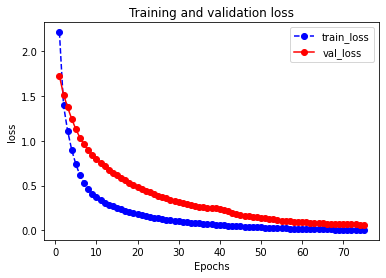

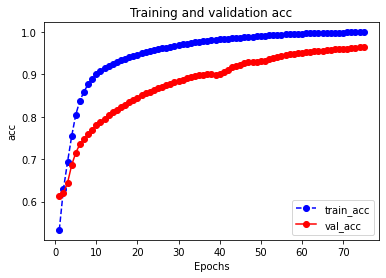

In [ ]:
def plot_metric(df_history, metric):
    plt.figure()
    imgs_dir = "./ritam"

    train_metrics = df_history[metric]
    val_metrics = df_history['val_' + metric]  #

    epochs = range(1, len(train_metrics) + 1)

    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')  #

    plt.title('Training and validation ' + metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_" + metric, 'val_' + metric])

    plt.savefig(imgs_dir + metric + '.png')  # Save Pictures
    plt.show()

plot_metric(df_history, 'loss')
plot_metric(df_history, metric_name)

In [ ]:
@torch.no_grad()
# def eval_step(model, inps, tags):
#     inps = torch.from_numpy(inps).to(device)
#     tags = torch.from_numpy(tags).to(device)
#     mask = torch.logical_not(torch.eq(inps, torch.tensor(0)))  # =>[b, seq_Len], each element is a bool value, and if there is a pad in the sequence, the corresponding position of the mask is False
#     # mask = mask.type(torch.uint8)
#     # mask = mask.to(device)

#     # forward
#     logits = model(inps)
#     preds = model.crf_decode(logits, mask=mask, inp_logits=True)  # List[List]
#     pred_without_pad = []
#     for pred in preds:
#         pred_without_pad.extend(pred)
#     tags_without_pad = torch.masked_select(tags, mask).cpu()  # Return to 1-D Tensor

#     return torch.tensor(pred_without_pad), tags_without_pad
def test_step(model, inps, tags):
    inps = torch.from_numpy(inps).to(device)
    tags = torch.from_numpy(tags).to(device)
    mask = torch.logical_not(torch.eq(inps, torch.tensor(0)))  # =>[batch, seq_Len], each element is a bool value, and if there is a pad in the sequence, the corresponding position of the mask is False
    
    mask = mask.type(torch.bool)
    mask = mask.to(device)

    model.eval()  # Set eval mode

    # forward
    logits = model(inps)
    loss = model.crf_neg_log_likelihood(logits, tags.long(), mask=mask, inp_logits=True)

    preds = model.crf_decode(logits, mask=mask, inp_logits=True)  # List[List]
    pred_without_pad = []
    for pred in preds:
        pred_without_pad.extend(pred)
    tags_without_pad = torch.masked_select(tags, mask).cpu()  # Return to 1-D Tensor
    metric = metric_func(pred_without_pad, tags_without_pad)
    # print('*' * 8, metric) # scalar

    return torch.tensor(pred_without_pad), tags_without_pad, len(pred_without_pad)

In [ ]:
def evaluate(model, X, Y):
    model.eval()  # Set eval mode
    starttime = time.time()
    print('*' * 27, 'start evaluating...')
    # printbar()
    preds, labels = [], []
    for step, (inps, tags) in enumerate(zip(X,Y), start=1):
        pred, tags,_ = test_step(model, inps, tags)
        preds.append(pred)
        labels.append(tags)

    y_true = torch.cat(labels, dim=0)
    y_pred = torch.cat(preds, dim=0)
    endtime = time.time()
    print('evaluating costs: {:.2f}s'.format(endtime - starttime))
    return y_true.cpu(), y_pred.cpu()

In [ ]:
from sklearn.metrics import precision_score,classification_report,f1_score,confusion_matrix,recall_score
import seaborn as sns

def get_metrics(y_true, y_pred):
    average = 'weighted'
    print('*'*27, average+'_precision_score:{:.3f}'.format(precision_score(y_true, y_pred, average=average)))
    print('*'*27, average+'_recall_score:{:.3}'.format(recall_score(y_true, y_pred, average=average)))
    print('*'*27, average+'_f1_score:{:.3f}'.format(f1_score(y_true, y_pred, average=average)))
    print("Micro F1",f1_score(y_true,y_pred,average='micro'))

    print('*'*27, 'accuracy:{:.3f}'.format(accuracy_score(y_true, y_pred)))
    print('*'*27, 'confusion_matrix:\n', sns.heatmap(confusion_matrix(y_true, y_pred),xticklabels=2, yticklabels=False))
    print('*'*27, 'classification_report:\n', classification_report(y_true, y_pred))

vocab size: 5969
*************************** Loading model weights...
*************************** Model loaded success!
*************************** start evaluating...
evaluating costs: 2.07s
*************************** weighted_precision_score:0.872
*************************** weighted_recall_score:0.88
*************************** weighted_f1_score:0.874
Micro F1 0.8798988621997472
*************************** accuracy:0.880


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


*************************** confusion_matrix:
 AxesSubplot(0.125,0.125;0.62x0.755)
*************************** classification_report:
               precision    recall  f1-score   support

           1       0.91      0.96      0.93     14671
           2       0.87      0.92      0.89      1107
           3       0.87      0.81      0.84       812
           4       0.86      0.82      0.84       802
           5       0.82      0.70      0.76       670
           6       0.84      0.84      0.84       692
           7       0.87      0.93      0.90       565
           8       0.68      0.63      0.66       500
           9       0.62      0.38      0.47       415
          10       0.62      0.56      0.59       461
          11       0.91      0.92      0.92       490
          12       0.89      0.69      0.78       424
          13       0.81      0.77      0.79       435
          14       0.81      0.81      0.81       379
          15       0.88      0.74      0.80       435


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


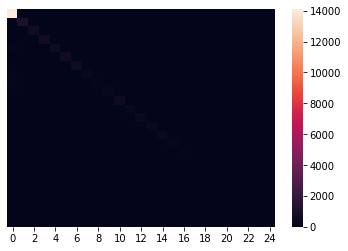

In [ ]:
print('vocab size:', len(word_index))

# checkpoint = "./ritam" + 'epoch020_valacc0.843_ckpt.tar'
PATH = "./best_model.sav"
# Load Test Data
# test_dloader = x_test_pad

# Load Model
reloaded_model = BiLSTM_CRF(vocab_size, hidden_size, embedding_dim, hidden_size,device=device)
reloaded_model = reloaded_model.to(device)

print('*' * 27, 'Loading model weights...')
# ckpt = torch.load(checkpoint, map_location=device)  # Dict save loads to GPU on CPU
reloaded_model.load_state_dict(torch.load(PATH))

print('*' * 27, 'Model loaded success!')


y_true, y_pred = evaluate(reloaded_model, x_test_batched , y_test_batched)
get_metrics(y_true, y_pred)